# Stratégie :

On récupère des données grace à l'accéléromètre smartphone, il faut les mettre dans un csv et enlever les entêtes à l'avance. Ensuite on leur met des labels (marche, assis, cours...) pour faire de la classification. Dans ce cadre, on utilise la fonction cree_label qui renvoie un dataframe de labels utilisables pour l'apprentissage. On peut concaténer tous les enregistrements labellisés dans un seul fichier pour l'utiliser comme train dans la classification. Concernant la direction du sol : on la cherche audébut en utilisant les 100 premiers points (0.2 secondes) ; ensuite on effectue une rotation appropriée pour que le vecteur que l'on a trouvé pointe toujours vers le bas.

Idées court terme : clustering (gaussian mixture, Kmeans), trouver des bonnes features d'explication des données(tf, moyennes variance, fenetrage), rajouter des enregistrements.

Idées long terme : EKF, mélanger toutes les méthodes pour améliorer la précisions, rajouter des activités à reconnaitre(vélo, escalier...), mieux prendre en compte la rotation du smartphone, utiliser deux smartphones. 

## Import

In [2]:
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cmath
import math
from scipy import signal
plt.style.use('seaborn-colorblind')

## Présentation des données / Processing

In [3]:
data = pd.read_csv('bus.csv', engine = 'python')
#data = data.get(['x', 'y', 'z', 'delta de t'])
#data = pd.DataFrame.transpose(data)
print(data.shape)

(11095, 4)


In [4]:
data.head(12)

,x,y,z,deltaT
0,0.344,8.042,5.656,0
1,0.483,7.783,5.722,5
2,0.564,7.664,5.779,5
3,0.575,7.661,5.822,5
4,0.606,7.705,5.860,5
5,0.891,7.827,5.731,5
6,1.140,7.872,5.576,5
7,1.121,7.765,5.300,5
8,0.971,7.612,4.994,5
9,0.850,7.490,4.688,5


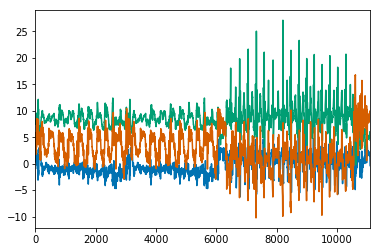

In [5]:
data['x'].plot()
data['y'].plot()
data['z'].plot()

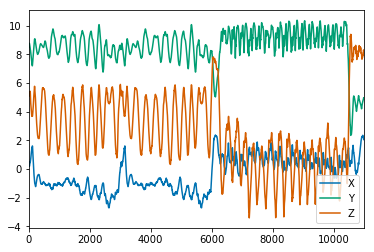

In [6]:
n = 100
filtre = np.ones(n)
# Il faudra trouver un filtre correct
filtre = np.array(filtre).reshape(len(filtre), 1)/len(filtre)
filteredX = signal.convolve(data.get(['x']), filtre)
filteredY = signal.convolve(data.get(['y']), filtre)
filteredZ = signal.convolve(data.get(['z']), filtre)
fdata = pd.DataFrame()
fdata['X'] = filteredX[n : - n, 0]
fdata['Y'] = filteredY[n : - n, 0]
fdata['Z'] = filteredZ[n : - n, 0]
fdata.plot()

   <div class="alert alert-success">
   
   Ici on a les données dans une DataFrame, les données brutes dans data et les filtrées dans fdata
</div>


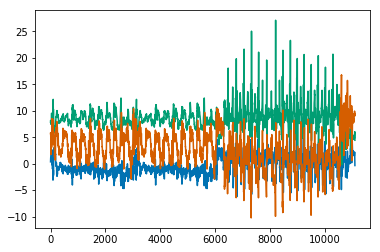

In [7]:
arrX = np.array(data.get(['x']))
arrY = np.array(data.get(['y']))
arrZ = np.array(data.get(['z']))
plt.figure()
plt.plot(arrX)
plt.plot(arrY)
plt.plot(arrZ)

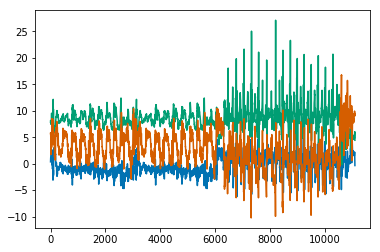

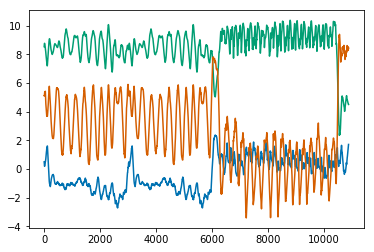

In [8]:
n = 100
filtre = np.ones(n)
# Il faudra trouver un filtre correct
filtre = np.array(filtre).reshape(len(filtre), 1)/len(filtre)
# print(filtre)
filteredX = signal.convolve(arrX, filtre)
filteredY = signal.convolve(arrY, filtre)
filteredZ = signal.convolve(arrZ, filtre)
# Original
plt.figure()
plt.plot(arrX)
plt.plot(arrY)
plt.plot(arrZ)
# Filtered
plt.figure()
plt.plot(filteredX[n :arrX.shape[0] - n])
plt.plot(filteredY[n :arrY.shape[0] - n])
plt.plot(filteredZ[n :arrZ.shape[0] - n])

#plt.figure()
#plt.plot(arrX[:arrX.shape[0]] - filteredX[:arrX.shape[0]])
#plt.plot(arrY[:arrY.shape[0]] - filteredY[:arrY.shape[0]])
#plt.plot(arrZ[:arrZ.shape[0]] - filteredZ[:arrZ.shape[0]])


#filtered_data = pd.DataFrame({'X' : filteredX, 'Y' : filteredY, 'Z' : filteredZ})

   <div class="alert alert-success">
   
   Ici on a les mêmes données, mais manipulées avec matplotlib et signal
</div>


## Rotation des données

J'essaie de récupérer l'accélération de la gravité. Quand on la connait, on peut identifier la direction du sol et ainsi faire une rotation pour pouvoir travailler dans un repère compris par la suite.

In [9]:
# Recherche de l'accélération de la gravité sur la première seconde

xg = arrX[:100].mean()
yg = arrY[:100].mean()
zg = arrZ[:100].mean()
G = [xg, yg, zg]
print(G)
print((xg**2 + yg**2 + zg**2)**0.5)

[0.52401999999999993, 8.5281200000000013, 5.1225999999999985]
9.96215129652


In [10]:
def angle(u, v):
    u = u/np.linalg.norm(u)
    v = v/np.linalg.norm(v)
    return np.arccos(np.clip(np.dot(u, v), -1.0, 1.0))

In [11]:
G_objectif = [0, 0, - 9.8]
# Il faut faire deux rotations
print(G)

# rotation autour de l'axe des ordonnées

#On cherche l'argument dans xoy du projeté de G
theta_z = cmath.phase(complex(G[0], G[1]))
print(theta_z)
rot_mat_z = [[math.cos(theta_z), - math.sin(theta_z), 0], [math.sin(theta_z), math.cos(theta_z), 0], [0, 0, 1]]
G_rot = np.dot(G, rot_mat_z)
print(G_rot)
# rotation autour de l'axe des abscisses

theta_y = cmath.phase(complex(G_rot[0], G_rot[2]))
rot_mat_y = [[math.sin(theta_y), 0, - math.cos(theta_y)], [0, 1, 0], [- math.cos(theta_y), 0, - math.sin(theta_y)]]
G_rot = np.dot(G_rot, rot_mat_y)
print(G_rot)

# Rotation complète

rot_mat = np.dot(rot_mat_z, rot_mat_y)
print(np.dot(G, rot_mat))

[0.52401999999999993, 8.5281200000000013, 5.1225999999999985]
1.5094273511482335
[  8.54420433e+00   6.66133815e-16   5.12260000e+00]
[  0.00000000e+00   6.66133815e-16  -9.96215130e+00]
[ -8.88178420e-16   6.66133815e-16  -9.96215130e+00]


In [12]:
def cree_labels(features, liste_transitions, liste_labels):
    #il faut bien avoir assez de label sinon on renvoie une erreur
    liste_transitions.append(len(features))
    #print(liste_transitions)
    labels = np.zeros(len(features))
    past_index = 0
    current_index = 0
    for k in range(len(liste_transitions)) :
        current_index = liste_transitions[k]
        labels[past_index : current_index] = liste_labels[k]
        #print(current_index)
        past_index = current_index
    return labels
    #features['labels'] = Y
    #return features

In [13]:
# Exemple d'attribution de labels

liste_labels = [0, 1, 2] # 0 c'est assis, 1 c'est sinus bus, 2 c'est marche
liste_transitions = [3037, 6071]
labels = cree_labels(fdata, liste_transitions, liste_labels)

### Tests de classification

In [14]:
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.decomposition import PCA

train, classes = shuffle(fdata, labels)
scaler = preprocessing.RobustScaler().fit(train) # ou StandardScaler
train_scaled = scaler.transform(train)

pca = PCA(svd_solver = 'randomized', n_components = 3)
train_scaled_pca = pca.fit_transform(train_scaled)

clf = BaggingClassifier(MLPClassifier(solver = 'adam', alpha = 1, max_iter = 200, shuffle = True, hidden_layer_sizes = (100, 100, 100)), n_estimators = 30, max_samples = 0.5)

clf.fit(train_scaled_pca, classes)

prediction = clf.predict(train_scaled_pca)

print(prediction)

[ 0.  1.  0. ...,  0.  2.  2.]
